In [22]:
# Assignment 1

import os
import re
import json

file_paths = []
for dirpath, dirnames, filenames in os.walk('results'):
    for filename in filenames:
        full_path = os.path.join(dirpath, filename)
        file_paths.append(full_path)

def numerical_sort_key(path):
    numbers = re.findall(r'\d+', path)
    return tuple(int(num) for num in numbers) if numbers else (0,)

file_paths.sort(key=numerical_sort_key)

results_dict = {}

for path in file_paths:
    folder_match = re.search(r'results/(\d+)', path)
    if folder_match:
        folder_num = int(folder_match.group(1))
        if folder_num not in results_dict:
            results_dict[folder_num] = {
                "duration_seconds": None,
                "Fermi_energy": None,
                "total_energy": None,
                "error": False
            }
        if path.endswith("duration.txt"):
            with open(path, "r") as f:
                first_line = f.readline().strip()
                parts = first_line.split(":")
                if len(parts) == 3:
                    h, m, s = map(int, parts)
                    total_seconds = h * 3600 + m * 60 + s
                    results_dict[folder_num]["duration_seconds"] = total_seconds
        if path.endswith("log.txt"):
            with open(path, "r")as f:
                for line in f:
                    if "the Fermi energy is" in line:
                        fe_match = re.search(r"the Fermi energy is\s*([-+]?\d*\.\d+|\d+)", line)
                        if fe_match:
                            results_dict[folder_num]["Fermi_energy"] = float(fe_match.group(1))
                    if "!    total energy" in line:
                        te_match = re.search(r"!    total energy\s*=\s*([-+]?\d*\.\d+|\d+)", line)
                        if te_match:
                            results_dict[folder_num]["total_energy"] = float(te_match.group(1))
                    if "error" in line.lower():
                        results_dict[folder_num]["error"] = True

with open("results_summary.json", "w") as json_file:
    json.dump(results_dict, json_file, indent=4)
    

/var/folders/sg/rs2mntr13ws5ttc315f3g7g80000gn/T/ipykernel_16756/3937983688.py:40: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(filename, skiprows=start_line, delim_whitespace=True, header=None, engine='python', encoding='utf-16')


Integral for range 104.63 to 147.88: 25.9755 W·°C·g^-1
Integral for range 68.54 to 121.06: 62.6757 W·°C·g^-1
Integral for range 83.14 to 155.89: 33.2079 W·°C·g^-1
Integral for range 108.96 to 122.75: 35.0666 W·°C·g^-1
Integral for range 98.31 to 149.57: 33.7647 W·°C·g^-1
Integral for range 84.13 to 119.38: 30.7685 W·°C·g^-1


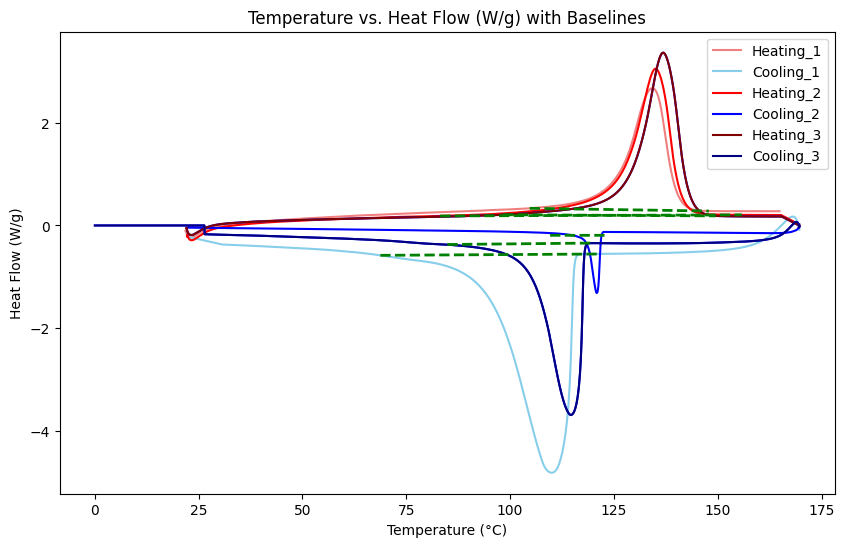

In [ ]:
#Assignment 2

# I typically use a software to integrate DSC peaks, but if I wanted to verify the accuracy of the software, the following script would be useful
# I am analyzing data from HDPE_Baseline.txt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def import_and_plot_data(filename):
    # Mass of the sample in mg and convert to grams
    sample_mass_mg = 7.27
    sample_mass_g = sample_mass_mg / 1000  # Convert mg to grams

    start_line = 0
    cooling_line = 0
    heat_line_2 = 0
    cooling_line_2 = 0
    heat_line_3 = 0
    cooling_line_3 = 0

    # Read the file to find where each phase starts
    with open(filename, 'r', encoding='utf-16') as file:
        for line_num, line in enumerate(file):
            if '3.33324E-4' in line:
                start_line = line_num
            elif '14.62533' in line:
                cooling_line = line_num + 1
            elif '27.83700' in line:
                heat_line_2 = line_num + 1
            elif '44.11200' in line:
                cooling_line_2 = line_num + 1
            elif '193.3753' in line:
                heat_line_3 = line_num + 1
            elif '209.0453' in line:
                cooling_line_3 = line_num + 1
                break

    # Calculate the range for the first cooling line
    flag = cooling_line - start_line

    # Read the data into a pandas DataFrame
    df = pd.read_csv(filename, skiprows=start_line, delim_whitespace=True, header=None, engine='python', encoding='utf-16')
    df = df.iloc[:, :3]
    df.columns = ['Time', 'Temperature', 'Heat Flow']

    # Convert heat flow to W/g
    df['Heat Flow'] = (df['Heat Flow'] / 1000) / sample_mass_g  # Convert mW to W and divide by sample mass in grams

    # Split the data into six phases
    heatup_1 = df.iloc[:flag, [1, 2]].copy()
    cooldown_1 = df.iloc[flag:heat_line_2, [1, 2]].copy()
    heatup_2 = df.iloc[heat_line_2:cooling_line_2, [1, 2]].copy()
    cooldown_2 = df.iloc[cooling_line_2:, [1, 2]].copy()
    heatup_3 = df.iloc[heat_line_3:cooling_line_3, [1, 2]].copy()
    cooldown_3 = df.iloc[cooling_line_3:, [1, 2]].copy()

    # Define different manual peak ranges for each phase
    manual_peak_ranges_heatup_1 = [(104.63, 147.88)]    # Manually set range for heating cycle 1
    manual_peak_ranges_cooldown_1 = [(68.54, 121.06)]  # Manually set range for cooling cycle 1
    manual_peak_ranges_heatup_2 = [(83.14, 155.89)]    # Manually set range for heating cycle 2
    manual_peak_ranges_cooldown_2 = [(108.96, 122.75)]  # Manually set range for cooling cycle 2
    manual_peak_ranges_heatup_3 = [(98.31, 149.57)]    # Manually set range for heating cycle 3
    manual_peak_ranges_cooldown_3 = [(84.13, 119.38)]  # Manually set range for cooling cycle 3

    def integrate_peaks_and_plot_baseline(temperature, heat_flow, manual_peak_ranges):
        integrals = []
        for start, end in manual_peak_ranges:
            # Define the region for integration
            region_temp = temperature[(temperature >= start) & (temperature <= end)]
            region_heat_flow = heat_flow[(temperature >= start) & (temperature <= end)]

            # Check if it's cooling 2 to apply a different baseline
            if (start, end) == (108.96, 122.75):  # Checking for cooling 2 range
                # Use a fixed level baseline (mean of heat flow just before and just after cooling 2)
                baseline_start = heat_flow[(temperature < start) & (temperature >= start - 5)].mean()
                baseline = np.full(len(region_temp), baseline_start)  # Fixed baseline- uses an average over a defined range
            else:
                # Calculate the linear baseline for other peaks
                baseline_start = region_heat_flow.iloc[0]  # Heat flow at the start of the range
                baseline_end = region_heat_flow.iloc[-1]   # Heat flow at the end of the range
                baseline = np.linspace(baseline_start, baseline_end, len(region_temp))  # Linear baseline

            # Subtract baseline from the heat flow values
            corrected_heat_flow = region_heat_flow - baseline

            # Integrate the area under the corrected curve (above baseline)
            integral = np.trapezoid(corrected_heat_flow, region_temp)
            integrals.append(float(integral))

            # Print the integral value and the corresponding temperature range
            print(f"Integral for range {start} to {end}: {integral:.4f} W·°C·g^-1")

            # Plot the baseline on the graph without including it in the legend
            plt.plot(region_temp, baseline, linestyle='--', color='green', linewidth=2)

        return integrals

    # Plot the data
    plt.figure(figsize=(10, 6))

    # Plot heat flow curves
    plt.plot(heatup_1['Temperature'], heatup_1['Heat Flow'], label="Heating_1", color='lightcoral')
    plt.plot(cooldown_1['Temperature'], cooldown_1['Heat Flow'], label="Cooling_1", color='skyblue')
    plt.plot(heatup_2['Temperature'], heatup_2['Heat Flow'], label="Heating_2", color='red')
    plt.plot(cooldown_2['Temperature'], cooldown_2['Heat Flow'], label="Cooling_2", color='blue')
    plt.plot(heatup_3['Temperature'], heatup_3['Heat Flow'], label="Heating_3", color='maroon')
    plt.plot(cooldown_3['Temperature'], cooldown_3['Heat Flow'], label="Cooling_3", color='navy')

    # Integrate under the peaks and plot baselines for each phase
    integrate_peaks_and_plot_baseline(heatup_1['Temperature'], heatup_1['Heat Flow'], manual_peak_ranges_heatup_1)
    integrate_peaks_and_plot_baseline(cooldown_1['Temperature'], cooldown_1['Heat Flow'], manual_peak_ranges_cooldown_1)
    integrate_peaks_and_plot_baseline(heatup_2['Temperature'], heatup_2['Heat Flow'], manual_peak_ranges_heatup_2)
    integrate_peaks_and_plot_baseline(cooldown_2['Temperature'], cooldown_2['Heat Flow'], manual_peak_ranges_cooldown_2)
    integrate_peaks_and_plot_baseline(heatup_3['Temperature'], heatup_3['Heat Flow'], manual_peak_ranges_heatup_3)
    integrate_peaks_and_plot_baseline(cooldown_3['Temperature'], cooldown_3['Heat Flow'], manual_peak_ranges_cooldown_3)

    # Set labels and title
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Heat Flow (W/g)')
    plt.title('Temperature vs. Heat Flow (W/g) with Baselines')
    plt.legend()
    plt.grid(False)
    plt.show()

filename = 'HDPE_Baseline.txt'
import_and_plot_data(filename)


In [ ]:
# Assignment 3

# Go through the ML4MSD-Files/Resources/Python_resources.md file and summarize any interesting observations or things you learned from it.

# I did not use the pathlib module for Assignment 1, but it seems like it would have been very helpful in simplifying my code based on the blog post about it
# I will take advantage of it in the future

# In the "open" function, the absence or presence of a + dictates whether or not you are reading/writing to a file
# a means you are appending a file, w means writing, and r means reading

# The Python standard library is so extensive! It's kind of overwhelming as a beginner. I'm looking forward to becoming more familiar with all of the different packages available

# I looked through all of the free python courses as well as the reddit thread
# I found a lot of suggestions to use "sololearn," people were comparing it to duolingo but for python
# It's free so I plan on taking advantage of the daily lessons!